# NoteFlow
- The first code cell of a noteflow is special and documents inputs and outputs via formatted comments.
- However, it is arbitrary code and can be used in anyway you like for local development and testing. In production, values provided by the user are inserted just below this cell. 
- The formatted comments (I/O spec) have three parts:
    - **input/ouput**: marks variable as an input or output
    - **type**: I/O is typed (for the underlying API). Types are: `string`, `number`, `boolean`, `filepath`, and `dirpath`
    - **description**: The rest of the comment becomes the prompt/description for the field in the generated App. 

In [1]:
image = 'test_images/image.png'         #input filepath   Image to Classify

prediction = None                       #output string    Predicted Class
prediction_plot = 'scores.png'          #output filepath  Class Predictions

## NoteFlow Supporting Files
- You can optionally upload supporting files with each noteflow (in addition to the notebook)

In [2]:
import pathlib

# This noteflow requires a pretrained model
imagenet_model_file = 'shufflenetv2_x1-5666bf0f80.pth'
assert pathlib.Path(imagenet_model_file).exists(), 'Error: Flow not configured correctly'

# This noteflow requires the class labels for the above model
imagenet_classes_file = 'imagenet_classes.txt'
assert pathlib.Path(imagenet_classes_file).exists(), 'Error: Flow not configured correctly'

## NoteFlow Libraries
- `numpy`, `pandas`, `matplotlib` and many others are pre-installed
- install missing libraries with `!pip install` 

In [3]:
import pandas as pd
import torch
from torchvision import models, transforms
import PIL

## Load Image File

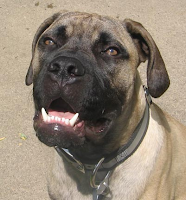

In [4]:
try:
    img = PIL.Image.open(image)
    thumb = img.copy() # show a small version in the notebook
    thumb.thumbnail((256, 256))
    display(thumb)
except:
    assert False, 'Error: Could not load provided image'

## Image Transform

In [5]:
# rotate accoring to EXIF header (iphones rotate images & mark with EXIF)
img = PIL.ImageOps.exif_transpose(img) 

In [6]:
# RGBA -> RGB (expecting 3 channel image)
img = img.convert('RGB') 

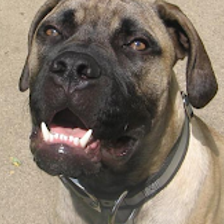

In [7]:
# Resize & crop
resize_crop = transforms.Compose([transforms.Resize(256, PIL.Image.BICUBIC), transforms.CenterCrop(224)])

img = resize_crop(img)
display(img)

In [8]:
# Convert to tensor and normalize
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.ToTensor(), normalize])
img_t = transform(img)

## Load model 
[ShuffleNet V2](https://arxiv.org/abs/1807.11164) as trained by [Torchvision](https://pytorch.org/vision/stable/index.html) on [ImageNet](https://imagenet.stanford.edu/)
- This model is small and fast (but not all that accurate)
- Note: You can download a pretrained model via: `models.shufflenet_v2_x1_0(pretrained=True)`

In [9]:
model = models.shufflenet_v2_x1_0(pretrained=False)
model.load_state_dict(torch.load(imagenet_model_file))
model = model.eval() # eval mode

In [10]:
with open(imagenet_classes_file) as f:
    imagenet_classes = pd.Series([c.strip() for c in f])
imagenet_classes.head()

0                                   tench, Tinca tinca
1                          goldfish, Carassius auratus
2    great white shark, white shark, man-eater, man...
3                      tiger shark, Galeocerdo cuvieri
4                         hammerhead, hammerhead shark
dtype: object

## Classify

In [11]:
batch = torch.unsqueeze(img_t, 0)
out = model(batch).detach()

In [12]:
percents = out.softmax(dim=1)[0] * 100
top5_vals, top5_inds = percents.topk(5)

In [13]:
scores = pd.DataFrame(top5_vals, imagenet_classes.loc[top5_inds])
scores.columns = ['scores']
scores.index.name = 'labels'
display(scores)

,scores
labels,
bull mastiff,99.893120
"American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier",0.069423
Great Dane,0.033759
boxer,0.001315
"Staffordshire bullterrier, Staffordshire bull terrier",0.000464


In [14]:
prediction = scores.index[0]
print(prediction)

bull mastiff


## Plot

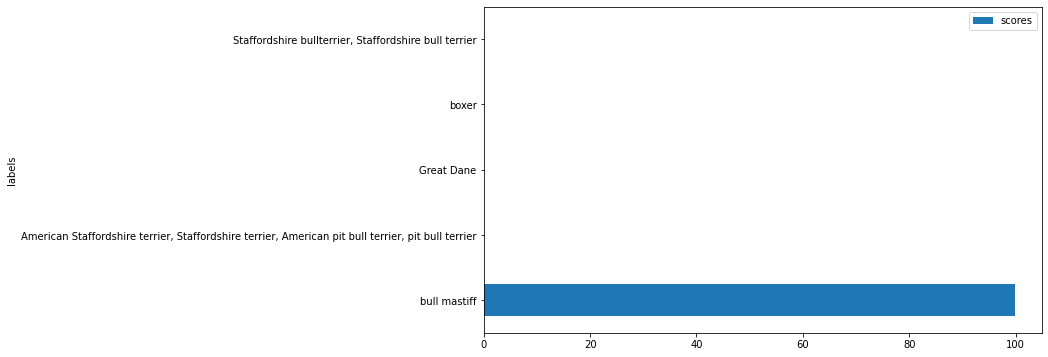

In [15]:
fig = scores.plot.barh( rot=0, figsize=(10, 6)).get_figure()

In [16]:
fig.savefig(prediction_plot, bbox_inches = 'tight')